In [27]:
import dask.dataframe as dd
import networkx as nx
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

from graph_reinforcement_learning_using_blockchain_data import config
import seaborn as sns

config.load_dotenv()

True

In [28]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [29]:
dd_class1 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_receipts.csv",
    dtype={
        "end_amount": "object",
        "error": "object",
        "profit_amount": "object",
        "start_amount": "object",
    },
)
dd_class1["receipt"] = dd_class1["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class1["logs"] = dd_class1["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [30]:
dd_class0 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts.csv"
)
dd_class0["receipt"] = dd_class0["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class0["logs"] = dd_class0["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [34]:
df_class0 = dd_class0.compute()
df_class1 = dd_class1.compute()

In [37]:
df_class0 = df_class0[df_class0["logs"].apply(lambda x: x is not None and len(x) > 0)]
df_class0 = df_class0.drop_duplicates(subset="transaction_hash")
df_class1 = df_class1.drop_duplicates(subset="transaction_hash")

In [7]:
def extract_transfer_addresses(log):
    topics = log["topics"]
    ERC20_TRANSFER_SIG = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
    if not topics:
        return None, None
    elif topics[0] != ERC20_TRANSFER_SIG:
        return None, None
    elif len(topics) < 3:
        return None, None
    from_address = "0x" + topics[1][-40:]
    to_address = "0x" + topics[2][-40:]
    return from_address, to_address

In [8]:
sig_to_idx = {}
idx_counter = 0


def create_transaction_graph(row, label):
    transaction_receipt = row["receipt"]
    logs = transaction_receipt.get("logs")

    edge_index = []
    edge_attr = []
    accounts = set()
    for log in logs:
        attr = []
        topic = log["topics"]
        global sig_to_idx
        if topic and topic[0] not in sig_to_idx:
            global idx_counter
            sig_to_idx[topic[0]] = idx_counter
            idx_counter += 1
        if topic:
            attr.append(sig_to_idx[topic[0]])
        else:
            attr.append(-1)

        if log["data"] == "0x":
            value = 0
        else:
            value = int(log["data"], 16)
        attr.append(value)

        from_addr, to_addr = extract_transfer_addresses(log)
        if from_addr is None or to_addr is None:
            continue
        accounts.add(from_addr)
        accounts.add(to_addr)

        edge_index.append([from_addr, to_addr])
        edge_attr.append(attr)

    accounts = list(accounts)
    mapping = {addr: i for i, addr in enumerate(accounts)}

    edge_index_numeric = []
    for src, dst in edge_index:
        edge_index_numeric.append([mapping[src], mapping[dst]])

    edge_index = torch.tensor(edge_index_numeric, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # node features
    num_nodes = len(accounts)
    degree = torch.zeros((num_nodes, 1))
    for src, dst in edge_index.t().tolist():
        degree[src] += 1
        degree[dst] += 1

    # global features
    gas_used = transaction_receipt["gasUsed"]
    effective_gas_price = transaction_receipt["effectiveGasPrice"]
    fee = gas_used * effective_gas_price
    status = transaction_receipt["status"]
    num_logs = len(logs)

    trx_id = transaction_receipt["transactionHash"]

    global_features = torch.tensor(
        [gas_used, effective_gas_price, fee, status, num_logs], dtype=torch.float
    )
    y = torch.tensor(label, dtype=torch.int)
    data = Data(x=degree, y=y, edge_index=edge_index, edge_attr=edge_attr)
    data.global_features = global_features
    data.account_mapping = mapping
    data.trx_id = trx_id
    return data

In [9]:
data = []
for _, row in df_class0.iterrows():
    data.append(create_transaction_graph(row, 0))

for _, row in df_class1.iterrows():
    data.append(create_transaction_graph(row, 1))

In [10]:
data[1].edge_attr.size()

torch.Size([3, 2])

In [15]:
sig_to_idx

{'0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31': 0,
 '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': 1,
 '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': 2,
 '0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1': 3,
 '0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822': 4,
 '0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c': 5,
 '0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67': 6,
 '0x4a4fc49abd237bfd7f4ac82d6c7a284c69daaea5154430cff04ad7482c6c4254': 7,
 '0xcba69f43792f9f399347222505213b55af8e0b0b54b893085c2e27ecbe1644f1': 8,
 '0x69b31548dea9b3b707b4dff357d326e3e9348b24e7a6080a218a6edeeec48f9b': 9,
 '0x4531cd5795773d7101c17bdeb9f5ab7f47d7056017506f937083be5d6e77a382': 10,
 '0xdec2bacdd2f05b59de34da9b523dff8be42e5e38e818c82fdb0bae774387a724': 11,
 '0x30385c845b448a36257a6a1716e6ad2e1bc2cbe333cde1e69fe849ad6511adfe': 12,
 '0xd83ff51c390bc39215ec64cfd850e02

In [21]:
df_class0.head(3)

,block_number,transaction_hash,receipt,logs
0,16950601,4d419ef95a879f7d3da5ad7b55289ba88e360d5df7d42b...,{'transactionHash': '0x8e90ecb85b61af368db0154...,[{'blockHash': '0xb6e2ade980aad8c2054ca26beb98...
1,16950601,5f7a16727b0ed026b1656924be454df15951fc3d135093...,{'transactionHash': '0xd83c25449d0766a18945f10...,[{'blockHash': '0xb4bb6a42db43c3a23bef597fceb9...
3,16950601,93211130eb153a9aafe8f6369f747e894750723a51c237...,{'transactionHash': '0x8d3b8e46a66a909643f2bb7...,[{'blockHash': '0x6939a55940dc342800e0f589d9f3...


In [28]:
data[4].global_topics

tensor([5, 2, 2, 2, 6])

In [11]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G, pos=nx.spring_layout(G, seed=42), with_labels=True, node_color=color, cmap="Set2"
    )
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42))
    plt.show()

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


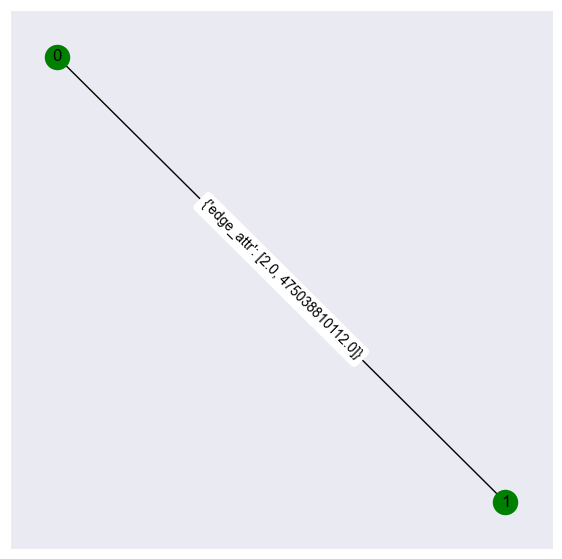

In [13]:
G = to_networkx(
    data[2],
    node_attrs=["x"],
    edge_attrs=["edge_attr"],
    graph_attrs=["global_features"],
    to_undirected=True,
)
visualize_graph(G, color="green")

In [14]:
torch.save(data, config.FLASHBOTS_Q2_DATA_DIR / "trx_graphs.pt")